<a href="https://colab.research.google.com/github/btrentini/data_science/blob/master/US_Census%2C_Bruno_Trentini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#US Census 

⚠ **Run notebook:** In the menu above click "Runtime > Run all" or press $CTRL + F9$   

Heads up: it will take a while to run everything!

## Task Summary

In summary, this is what this notebook does:

- Extracts and Prepares dataset from http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip
- EDA and Feature Engineering
- Learns, for a dataset formed by vectors $\{x_n\}_{n=0}^N$, N the number of training examples, a model for the label $y_n$.  
- Predicts, given an a vector $x_n=\{x_n^0, x_n^1, ..., x_n^k\}$, $k$ the number of features, and the model learnt, if target variable, $y$ (salary), is greater than or equal to \$50,000 per year, yielding a prediction $\hat{y_n}$ for each training example $x_n$.
- Test different models and validate on test set the cross-entropy loss $L = - \sum_n y_n \, \,log \, \hat{y_n} + (1- y_n)log(1-\hat{y_n})$ that yields the lowerst error for the pair $(y, \hat{y})$ 



## Task Info

The following link lets you download an archive containing an “exercise” US Census dataset: http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip
This US Census dataset contains detailed but anonymized information for approximately 300,000 people.

>The archive contains 3 files: 
* A large training file (csv)
* Another test file (csv)
* A metadata file (txt) describing the columns of the two csv files (identical for both)

> **The goal** of this exercise is to model the information contained in the last column (42nd), i.e., whether a person makes more or less than $50,000 per year, from the information contained in the other columns. The exercise here consists of modeling a binary variable.

> Work with Python (or R) to carry out the following steps:
*  Load the train and test files.
* Perform an exploratory analysis on the data and create some relevant visualisations.
* Clean, preprocess, and engineer features in the training data, with the aim of building a data set that a model will perform well on.
* Create a model using these features to predict whether a person earns more or less than $50,000 per year. Here, the idea is for you to test a few different models, and see whether there are any techniques you can apply to improve performance over your first results.
* Choose the model that appears to have the highest performance based on a comparison between reality (the 42nd variable) and the model’s prediction. 
* Apply your model to the test file and measure its real performance on it (same method as above).

>The goal of this exercise is not to create the best or the purest model, but rather to describe the steps you took to accomplish it.
Explain areas that may have been the most challenging for you.
>Find clear insights on the profiles of the people that make more than $50,000 / year. For example, which variables seem to be the most correlated with this phenomenon?
>Finally, you push your code on GitHub to share it with me, or send it via email.

>Once again, the goal of this exercise is not to solve this problem, but rather to spend a few hours on it and to thoroughly explain your approach.

## Metadata Info

**From the metadata (see below how this was obtained):**


> This data was extracted from the census bureau database found at
>http://www.census.gov/ftp/pub/DES/www/welcome.html

>Donor: Terran Lane and Ronny Kohavi
       Data Mining and Visualization
       Silicon Graphics.
       e-mail: terran@ecn.purdue.edu, ronnyk@sgi.com for questions.


>The data was split into train/test in approximately $2/3$, $1/3$ proportions using MineSet's MIndUtil mineset-to-mlc.

>**Prediction task** is to determine the income level for the person represented by the record.  Incomes have been binned at the $50K level to present a binary classification problem, much like the original UCI/ADULT database.  The goal field of this data, however, was drawn from the "total person income" field rather than the "adjusted gross income" and may, therefore, behave differently than the orginal ADULT goal field.
>More information detailing the meaning of the attributes can be found in http://www.bls.census.gov/cps/cpsmain.htm

# Setup

## Check GPU configs

In [2]:
!nvidia-smi

Fri Sep 25 15:43:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [4]:
!pip install wget

In [5]:
!pip install imbalanced-learn

## Imports

In [6]:
# System utils
import sys
import os
import zipfile
import time

# Parallelism
from joblib import Parallel, delayed

# Some classic data science stuff
import numpy as np; 
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline 

# Math & Stats
import math 
import scipy.stats as stats
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor  

# Machine Learning libs
from sklearn.svm import LinearSVC 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, plot_importance, plot_tree

# Scikit learn utils
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
# Styling
sns.set_style("ticks", {"xtick.major.size": 11, "ytick.major.size": 11})
sns.set_palette("inferno")
sns.set(font_scale = 2)
figsize=(23, 15)
pal='inferno'
div = "="*72

# Build datasets

## Download & Extract

In [8]:
!wget "http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip"

--2020-09-25 15:44:00--  http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip
Resolving thomasdata.s3.amazonaws.com (thomasdata.s3.amazonaws.com)... 52.217.68.36
Connecting to thomasdata.s3.amazonaws.com (thomasdata.s3.amazonaws.com)|52.217.68.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9801875 (9.3M) [application/zip]
Saving to: ‘us_census_full.zip.2’

us_census_full.zip. 100%[===================>]   9.35M  11.8MB/s    in 0.8s    

2020-09-25 15:44:01 (11.8 MB/s) - ‘us_census_full.zip.2’ saved [9801875/9801875]



In [9]:
!ls -1

sample_data
us_census_full.zip
us_census_full.zip.1
us_census_full.zip.2


In [10]:
# Define helper to load
local_zip =os.path.join('/content', 'us_census_full.zip')

# Unzip Train Set into temporary path
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [11]:
!ls -1 /tmp

__MACOSX
us_census_full


In [12]:
train     = '/tmp/us_census_full/census_income_learn.csv'
test      = '/tmp/us_census_full/census_income_test.csv'
metadata  = '/tmp/us_census_full/census_income_metadata.txt'

In [13]:
# Let's see what's in the metadata
!fold -w 130 -s $metadata

| This data was extracted from the census bureau database found at
| http://www.census.gov/ftp/pub/DES/www/welcome.html
| Donor: Terran Lane and Ronny Kohavi
|        Data Mining and Visualization
|        Silicon Graphics.
|        e-mail: terran@ecn.purdue.edu, ronnyk@sgi.com for questions.
|
| The data was split into train/test in approximately 2/3, 1/3
| proportions using MineSet's MIndUtil mineset-to-mlc.
|
| Prediction task is to determine the income level for the person
| represented by the record.  Incomes have been binned at the $50K
| level to present a binary classification problem, much like the
| original UCI/ADULT database.  The goal field of this data, however,
| was drawn from the "total person income" field rather than the
| "adjusted gross income" and may, therefore, behave differently than the
| orginal ADULT goal field.
|
| More information detailing the meaning of the attributes can be
| found in http://www.bls.census.gov/cps/cpsmain.htm
| To make use of the data d

In [14]:
# Check if there's a header in the train file
!head -2 $train

73, Not in universe, 0, 0, High school graduate, 0, Not in universe, Widowed, Not in universe or children, Not in universe, White, All other, Female, Not in universe, Not in universe, Not in labor force, 0, 0, 0, Nonfiler, Not in universe, Not in universe, Other Rel 18+ ever marr not in subfamily, Other relative of householder, 1700.09, ?, ?, ?, Not in universe under 1 year old, ?, 0, Not in universe, United-States, United-States, United-States, Native- Born in the United States, 0, Not in universe, 2, 0, 95, - 50000.
58, Self-employed-not incorporated, 4, 34, Some college but no degree, 0, Not in universe, Divorced, Construction, Precision production craft & repair, White, All other, Male, Not in universe, Not in universe, Children or Armed Forces, 0, 0, 0, Head of household, South, Arkansas, Householder, Householder, 1053.55, MSA to MSA, Same county, Same county, No, Yes, 1, Not in universe, United-States, United-States, United-States, Native- Born in the United States, 0, Not in uni

In [15]:
# Check if there's a header in the test file
!head -2 $test

38, Private, 6, 36, 1st 2nd 3rd or 4th grade, 0, Not in universe, Married-civilian spouse present, Manufacturing-durable goods, Machine operators assmblrs & inspctrs, White, Mexican (Mexicano), Female, Not in universe, Not in universe, Full-time schedules, 0, 0, 0, Joint one under 65 & one 65+, Not in universe, Not in universe, Spouse of householder, Spouse of householder, 1032.38, ?, ?, ?, Not in universe under 1 year old, ?, 4, Not in universe, Mexico, Mexico, Mexico, Foreign born- Not a citizen of U S , 0, Not in universe, 2, 12, 95, - 50000.
44, Self-employed-not incorporated, 37, 12, Associates degree-occup /vocational, 0, Not in universe, Married-civilian spouse present, Business and repair services, Professional specialty, White, All other, Female, Not in universe, Not in universe, PT for econ reasons usually PT, 0, 0, 2500, Joint both under 65, Not in universe, Not in universe, Spouse of householder, Spouse of householder, 1462.33, ?, ?, ?, Not in universe under 1 year old, ?, 

In [16]:
%time df  = pd.read_csv(train, header=None)
%time t_df = pd.read_csv(test, header=None) 

CPU times: user 1.19 s, sys: 98.6 ms, total: 1.29 s
Wall time: 1.29 s
CPU times: user 605 ms, sys: 9.96 ms, total: 615 ms
Wall time: 614 ms


In [17]:
# Check
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


## A trick from metadata for column names
 This will help us a lot during EDA. The metada contains useful information about columns, values and their properties. I can use this file to name columns and later on this will give us the option to address the dataframe by column names, which might be handy in many cases

In [18]:
!tail -42 $metadata

age: continuous.
class of worker: Not in universe, Federal government, Local government, Never worked, Private, Self-employed-incorporated, Self-employed-not incorporated, State government, Without pay.
detailed industry recode: 0, 40, 44, 2, 43, 47, 48, 1, 11, 19, 24, 25, 32, 33, 34, 35, 36, 37, 38, 39, 4, 42, 45, 5, 15, 16, 22, 29, 31, 50, 14, 17, 18, 28, 3, 30, 41, 46, 51, 12, 13, 21, 23, 26, 6, 7, 9, 49, 27, 8, 10, 20.
detailed occupation recode: 0, 12, 31, 44, 19, 32, 10, 23, 26, 28, 29, 42, 40, 34, 14, 36, 38, 2, 20, 25, 37, 41, 27, 24, 30, 43, 33, 16, 45, 17, 35, 22, 18, 39, 3, 15, 13, 46, 8, 21, 9, 4, 6, 5, 1, 11, 7.
education: Children, 7th and 8th grade, 9th grade, 10th grade, High school graduate, 11th grade, 12th grade no diploma, 5th or 6th grade, Less than 1st grade, Bachelors degree(BA AB BS), 1st 2nd 3rd or 4th grade, Some college but no degree, Masters degree(MA MS MEng MEd MSW MBA), Associates degree-occup /vocational, Associates degree-academic program, Doctorate deg

From the above we can see that the last 42 rows are the column names
We can use this info to improve our datasets and help us eith EDA. Besides, the metada tells us to ignore '|_instance_weight' the 24th record



In [19]:
# We will beed a list to append to...
cols = []

# Save metadata last 42 rows
column_names = !tail -42 $metadata

# Remove the record to be ignored '|_instance_weight'
column_names.pop(24)        

# Build column helper
for col in column_names:
  record = col.split(":")[0].replace(" ","_")
  cols.append(record)

# Add target variable's column not listed in metadata
cols.append("target")

# Insert column names into dataframes
df.columns = cols
t_df.columns = cols

# Voila!
df.head(5)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,instance_weight,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [20]:
df.target.value_counts()

 - 50000.    187141
 50000+.      12382
Name: target, dtype: int64

**Note:** Dataset quite unbalanced...So we have two options:

- Either do Downscaling / Upscaling; Or
- Create a method that accounts for this imbalance in the proper way

I prefer the second as we need to model the data's true nature. Advanced techniques exist (deriving from Bayesian Methods, for example), but since I know my objetive is classification, I'll focus on the binary-classification model)

**Transform year columns** as its obvious from Metadata it shouldn't be continuous

In [21]:
df.head(5)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,instance_weight,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


## Categorise data 

Lets convert objects into categorical values so that we can manipulate them numerically

In [22]:
obj = df.select_dtypes(['object'])
df[obj.columns] = obj.apply(lambda x: x.str.strip().replace(" ",""))

In [23]:
df_bkp = df.copy()
t_df = t_df.copy()

for col in df.columns:
  if df[col].dtype == 'object':
    df[col] = df[col].str.strip().replace(" ","").astype('category').cat.codes
    t_df[col] = t_df[col].str.strip().replace(" ","").astype('category').cat.codes

df.dtypes

age                                             int64
class_of_worker                                  int8
detailed_industry_recode                        int64
detailed_occupation_recode                      int64
education                                        int8
wage_per_hour                                   int64
enroll_in_edu_inst_last_wk                       int8
marital_stat                                     int8
major_industry_code                              int8
major_occupation_code                            int8
race                                             int8
hispanic_origin                                  int8
sex                                              int8
member_of_a_labor_union                          int8
reason_for_unemployment                          int8
full_or_part_time_employment_stat                int8
capital_gains                                   int64
capital_losses                                  int64
dividends_from_stocks       

## Are there null / undefined values?

There are a few records marked with "$?$" but we will treat this as a category... So I wonder if there are columns with null values or "na" values


In [24]:
null_columns=df.columns[df.isnull().any()]
if len(null_columns) > 0:
  print(df[null_columns].isnull().sum())
else:
  print("No null columns")

na_columns=df.columns[df.isna().any()]
if len(na_columns) > 0:
  print(df[na_columns].isna().sum())
else:
  print("No NA columns")

No null columns
No NA columns


## Are there duplicates?

In [25]:
if df.duplicated().sum() > 0:
  print(df.duplicated().sum(), " dupicated records found and dropped")
  df.drop_duplicates(inplace=True)

3229  dupicated records found and dropped


# Exploratory Data Analysis

## Feature Importance

Start with a simple light GBM for estimating feature importance

In [26]:
model = LGBMClassifier(learning_rate=0.01, num_leaves= 33, random_state=42)
model.fit(df.iloc[:,0:41], df.iloc[:,0])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=33, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]),
 <a list of 41 Text major ticklabel objects>)

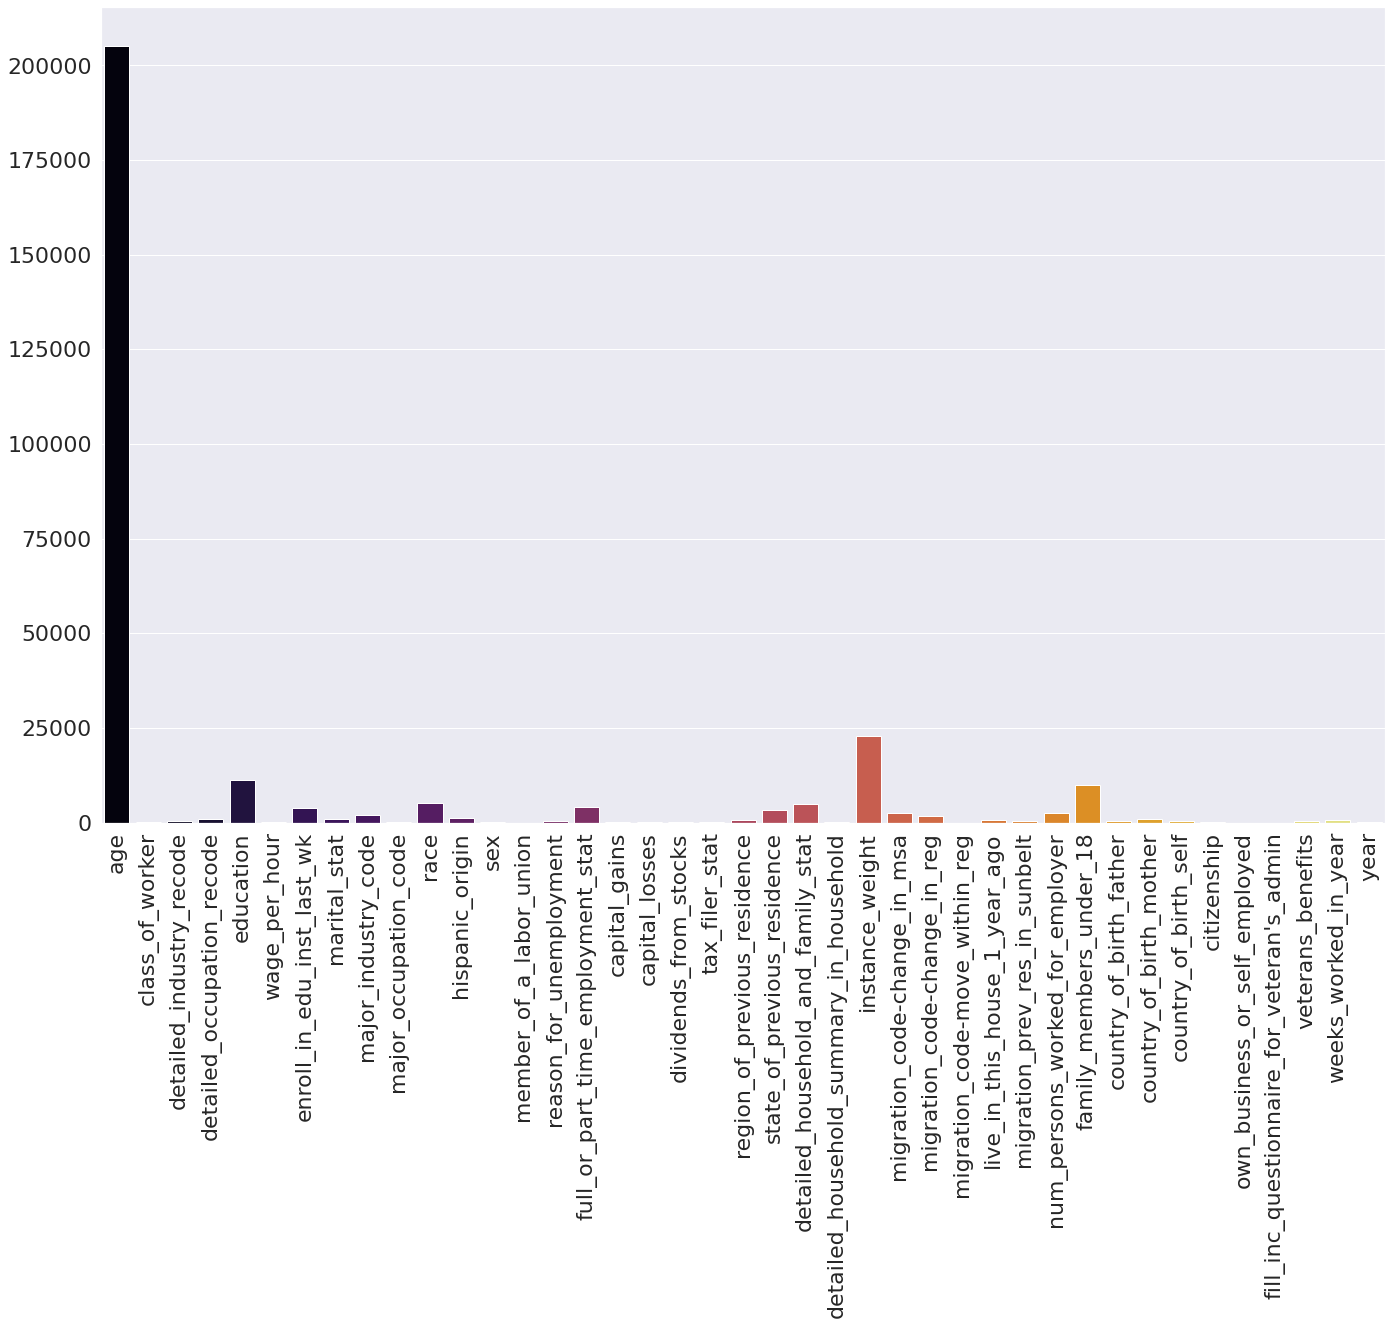

In [27]:
fig, ax = plt.subplots(figsize=(figsize))
ax = sns.barplot(y=model.feature_importances_, x=df.iloc[:,0:41].columns, palette=pal)
plt.xticks(rotation=90)

**This is very strange!** in real life we know that age, although a good indicator, can't play alone such an important weight in determining someone's income. There must exist some colinearity in the data (or worse things!). Let's check:

## Correlation

Will help us understand risks of colinearity and some features that we can get scrap. We will only consider features with moderate (>0.5), strong (>0.7) and very strong (>0.9) correlation in absolute values

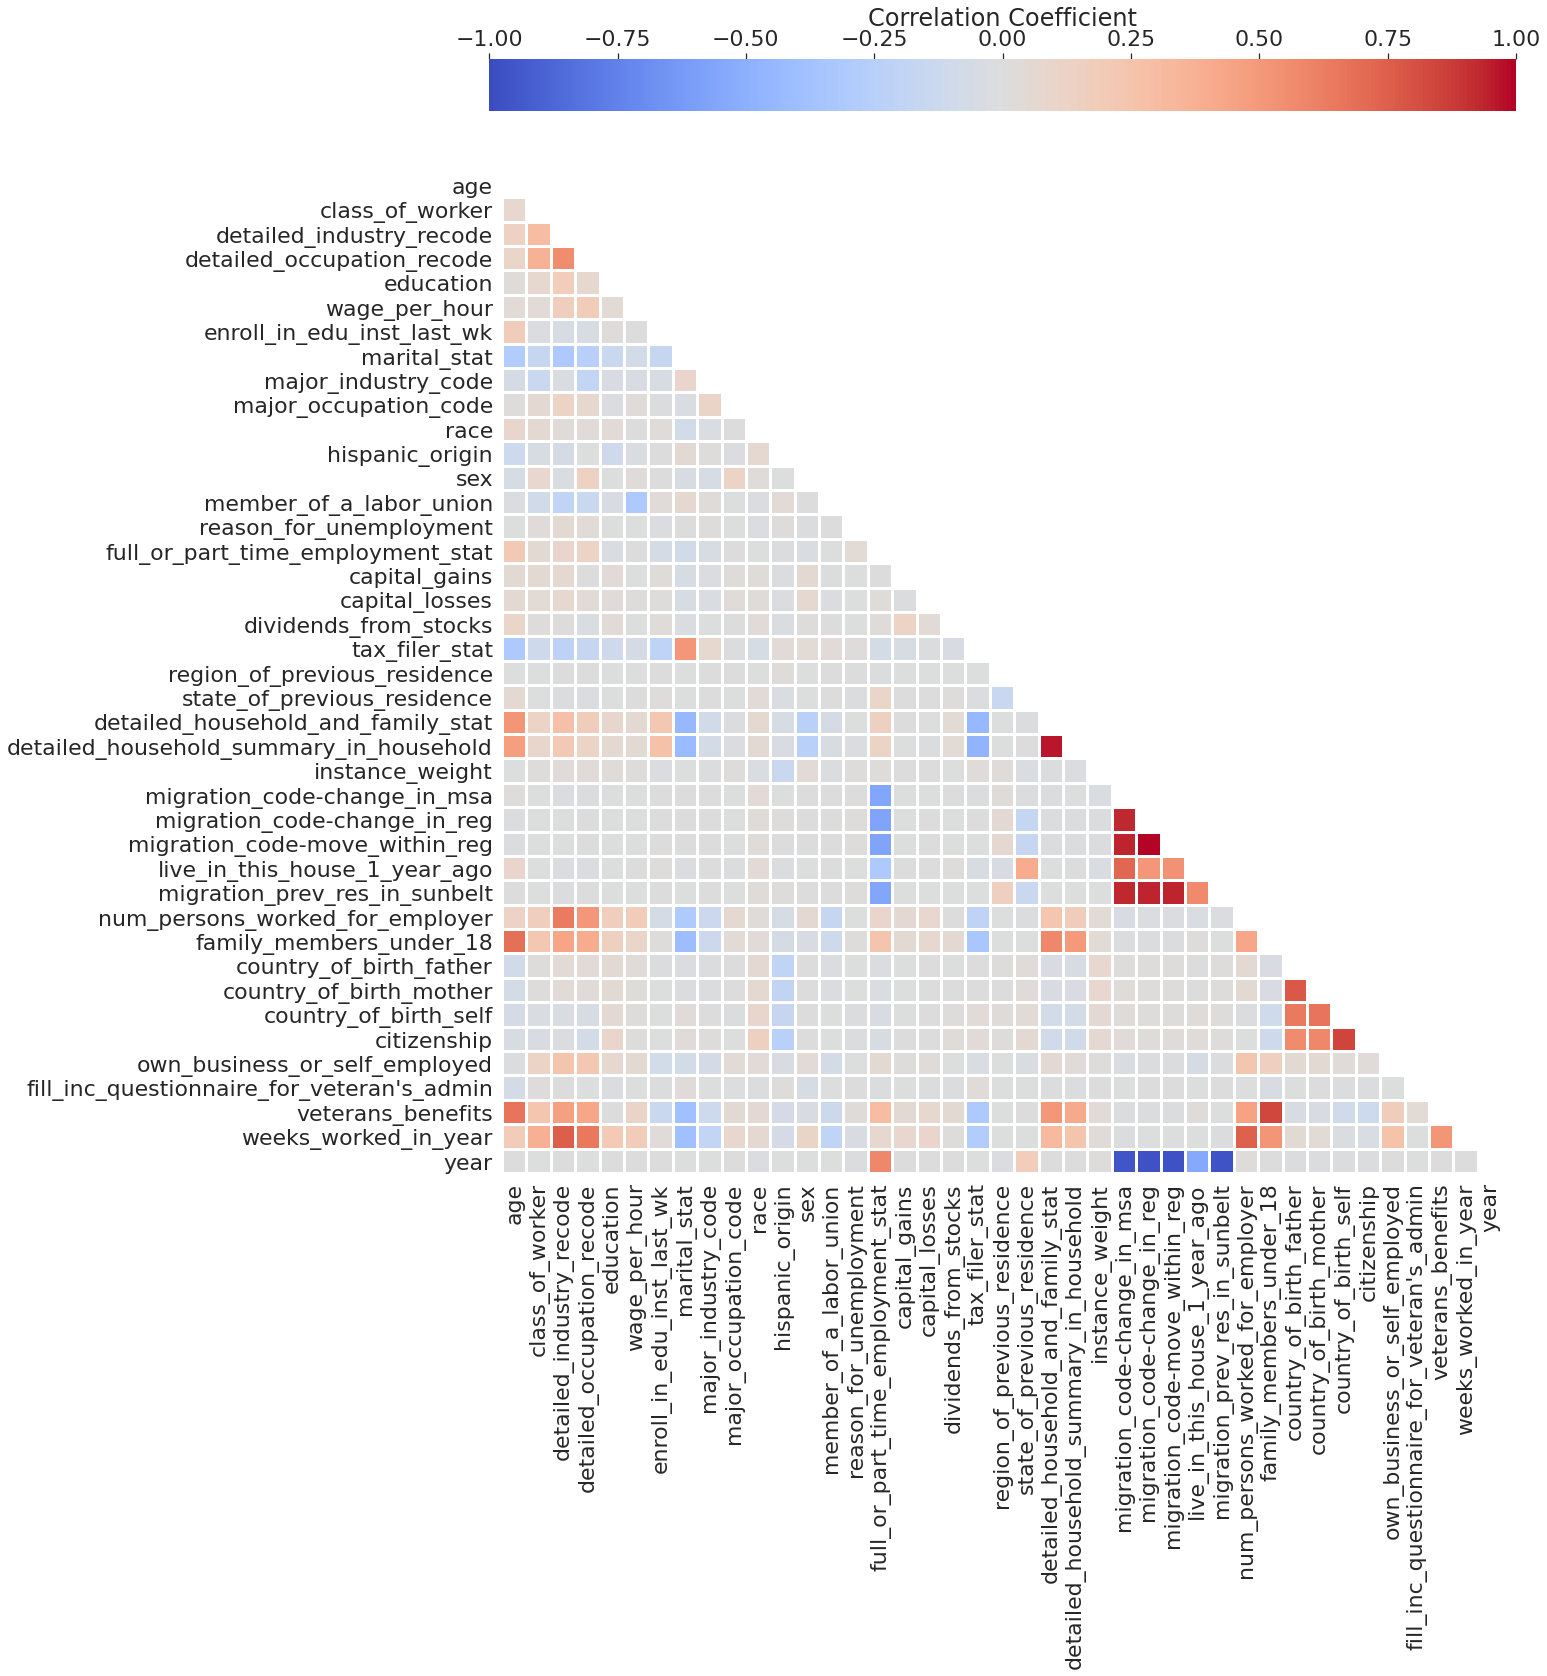

In [28]:
correlation = df.drop(['target'], axis=1).corr()
mask = np.triu(correlation)
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(23,23))
  #ax = sns.heatmap(correlation[(correlation > 0.5) | (correlation < -0.5)],
  ax = sns.heatmap(correlation,
              square=True,
              vmax=1.0,
              vmin=-1.0,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              mask=mask,
              annot=False, 
              fmt=".2f",
              robust=True,
              cbar=True,
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

### Variance Inflation Factor(VIF)
From wikipedia: VIF is the quotient of the variance in a model with multiple terms by the variance of a model with one term alone. It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. It provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity.

> Multicollinearity is a common phenomenon in high‐dimensional settings, in which two or more predictor variables are highly correlated [Zhao et al, 2020]( https://doi.org/10.1002/sta4.272)

This is a bit of a controversial topic and "tule of thumb" tresholds are dangerous as pointed in [A Caution Regarding Rules of Thumb
for Variance Inflation Factors](https://www.researchgate.net/profile/Robert_Obrien8/publication/226005307_A_Caution_Regarding_Rules_of_Thumb_for_Variance_Inflation_Factors/links/54d0f2620cf298d656695641/A-Caution-Regarding-Rules-of-Thumb-for-Variance-Inflation-Factors.pdf). The lowest VIF valuee is 1. Anything beyond 10 is extreme. Most people choose either $3$, $4$ or $5$ as treshold. We will go with $4$.

❌ We have $k=41$ features. With large $k$ this would be innapropriate but there are solusions like the one proposed in [Zhao et al, 2020]( https://doi.org/10.1002/sta4.272)


In [29]:
X = add_constant(df.iloc[:,0:41])
multico_indx=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

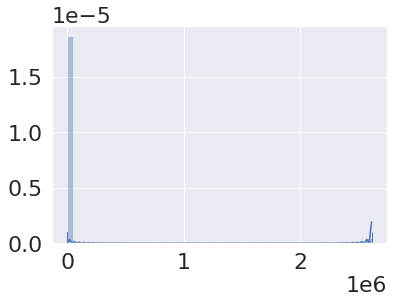

In [30]:
sns.distplot(multico_indx, rug=True)

In [31]:
df.iloc[:,np.where((multico_indx[1:] < 4)==True)[0][:].tolist()].dtypes

age                                             int64
class_of_worker                                  int8
detailed_industry_recode                        int64
detailed_occupation_recode                      int64
education                                        int8
wage_per_hour                                   int64
enroll_in_edu_inst_last_wk                       int8
marital_stat                                     int8
major_industry_code                              int8
major_occupation_code                            int8
race                                             int8
hispanic_origin                                  int8
sex                                              int8
member_of_a_labor_union                          int8
reason_for_unemployment                          int8
full_or_part_time_employment_stat                int8
capital_gains                                   int64
capital_losses                                  int64
dividends_from_stocks       

In [32]:
df = df.iloc[:,np.where((multico_indx[1:] < 4)==True)[0][:].tolist()]
df['target'] = df_bkp['target'].astype('category').cat.codes

In [33]:
df.head(5)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,instance_weight,num_persons_worked_for_employer,country_of_birth_father,country_of_birth_mother,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,target
0,73,3,0,0,12,0,2,6,14,6,4,0,0,1,3,2,0,0,0,4,3,36,1700.09,0,40,40,4,0,1,0
1,58,6,4,34,16,0,2,0,4,8,4,0,1,1,3,0,0,0,0,0,4,5,1053.55,1,40,40,4,0,1,0
2,18,3,0,0,0,0,1,4,14,6,1,0,0,1,3,2,0,0,0,4,3,36,991.95,0,41,41,0,0,1,0
3,9,3,0,0,10,0,2,4,14,6,4,0,0,1,3,0,0,0,0,4,3,36,1758.14,0,40,40,4,0,1,0
4,10,3,0,0,10,0,2,4,14,6,4,0,0,1,3,0,0,0,0,4,3,36,1069.16,0,40,40,4,0,1,0


### Post VIF check feature importance

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text major ticklabel objects>)

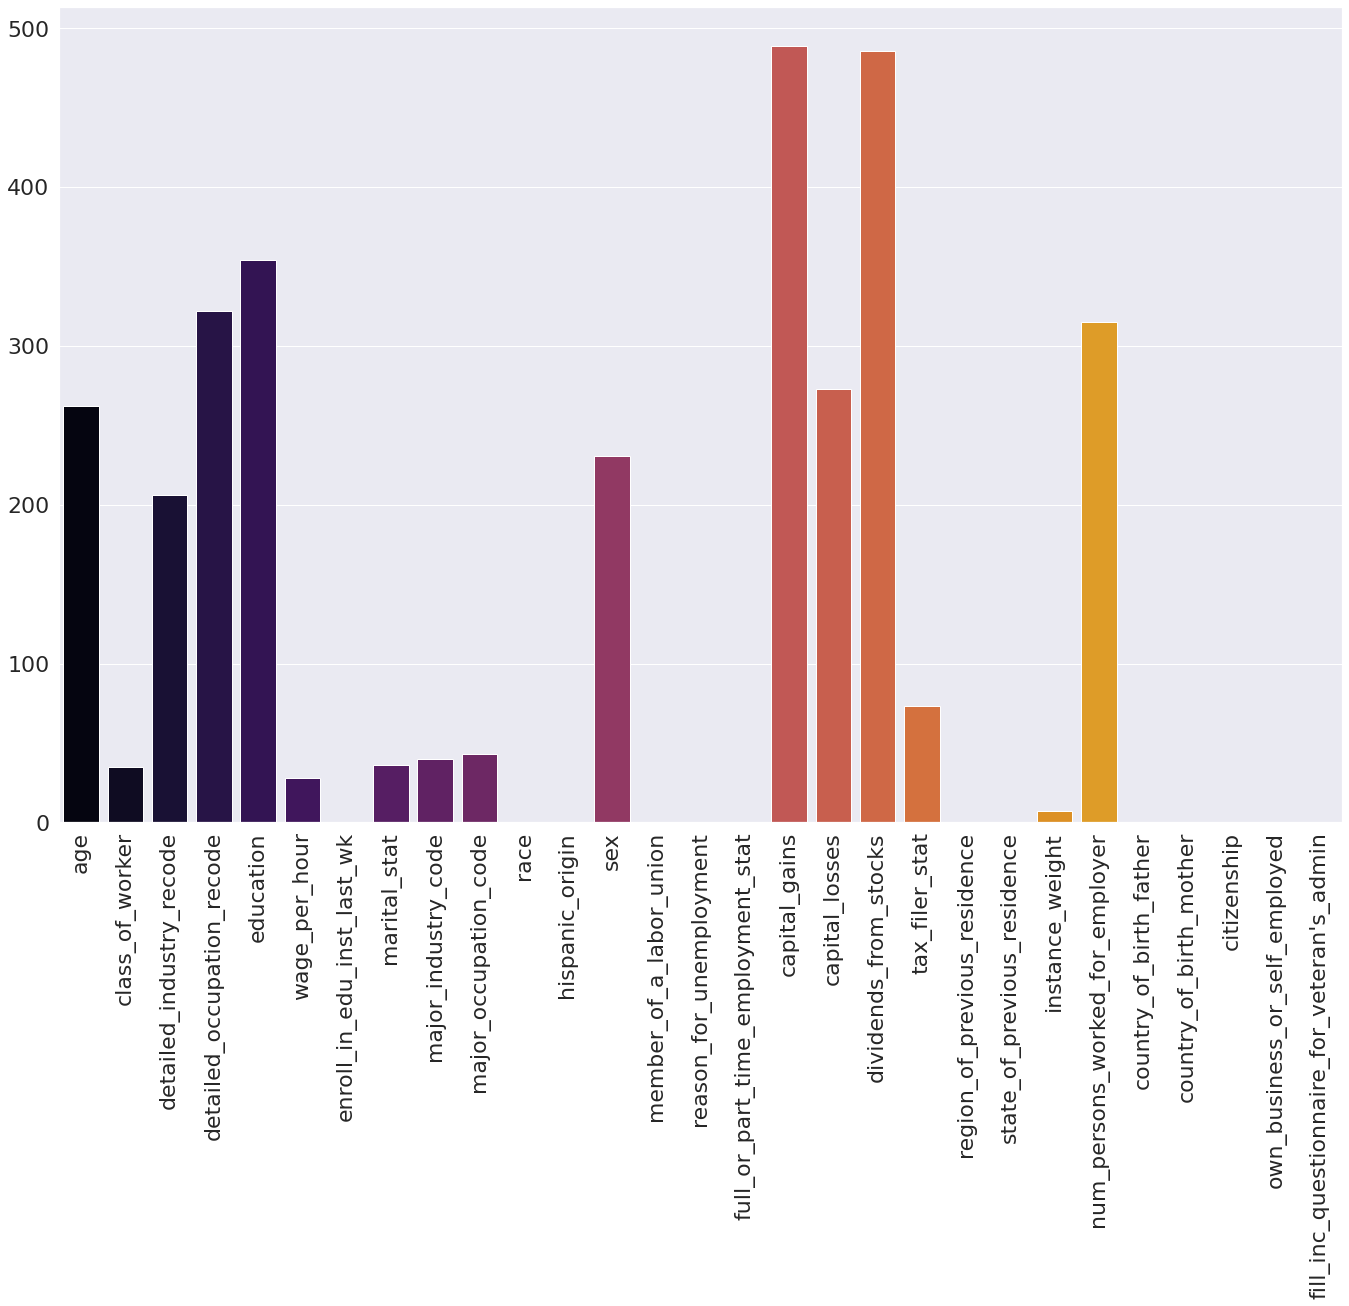

In [34]:
model = LGBMClassifier(learning_rate=0.01, num_leaves= 33, random_state=42)
model.fit(df.iloc[:,:-1], df.iloc[:,-1])

fig, ax = plt.subplots(figsize=(figsize))
ax = sns.barplot(y=model.feature_importances_, x=df.iloc[:,:-1].columns, palette=pal)
plt.xticks(rotation=90)

**That makes more sense!**

### Post VIF check correlation

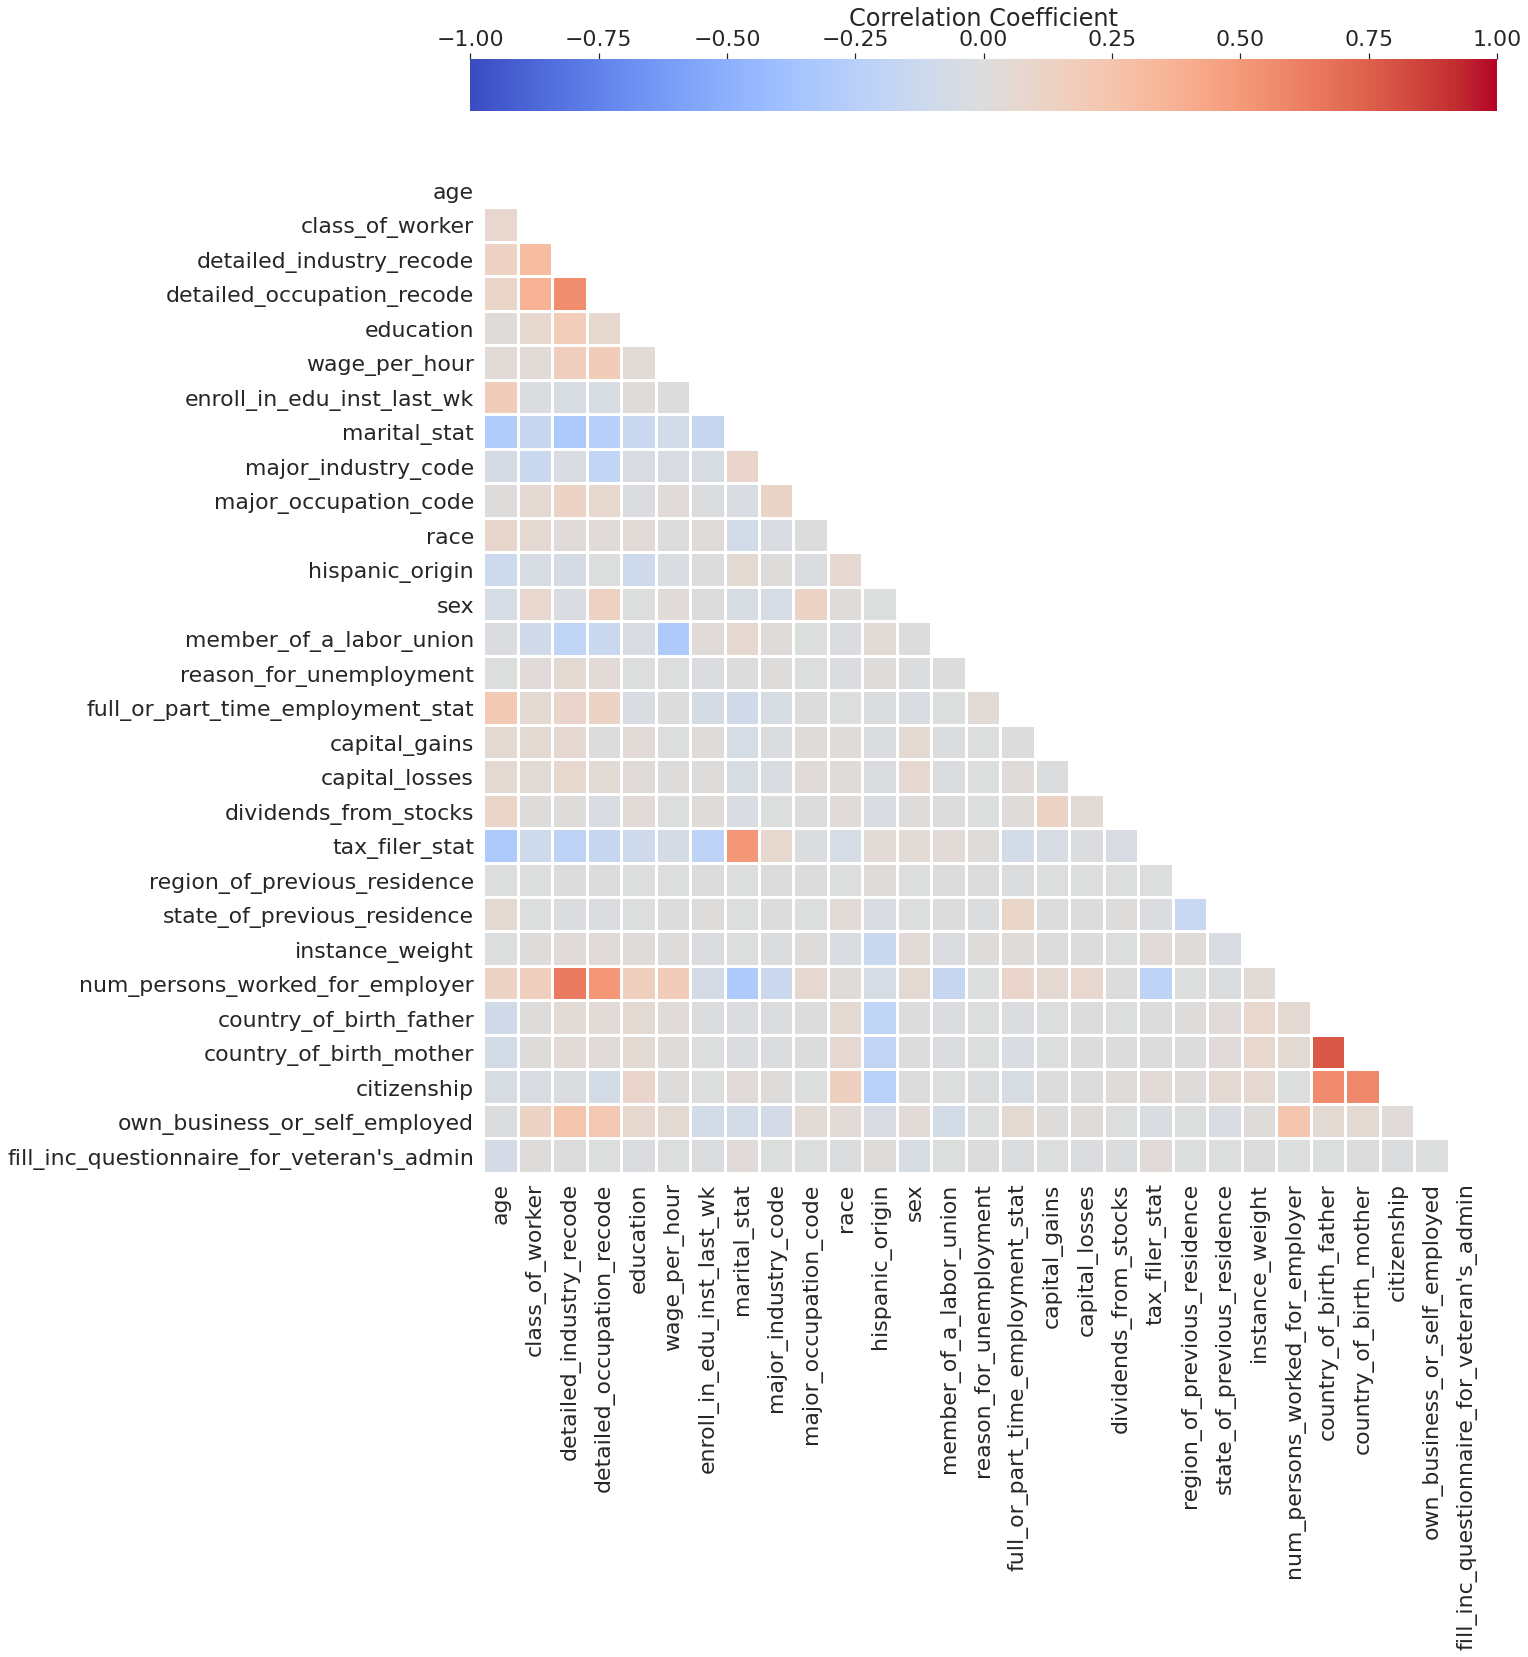

In [35]:
correlation = df.drop(['target'], axis=1).corr()
mask = np.triu(correlation)
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(23,23))
  #ax = sns.heatmap(correlation[(correlation > 0.5) | (correlation < -0.5)],
  ax = sns.heatmap(correlation,
              square=True,
              vmax=1.0,
              vmin=-1.0,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              mask=mask,
              annot=False, 
              fmt=".2f",
              robust=True,
              cbar=True,
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

## Remove not-so-important features with moderate correaltion or higher

It Looks like country of birth from father and mother are moderately correlated with citizenship. Since we can (almost) always derive someone's citizenship from their parents' place of birth and assuming parents' nationality do not play an imediate factor in someone's wages (setting apart deeper social analyses) and considering neither parent's origin appears as a crucial feature in our Light GBM model, we will remove these features to simplify our model further

In [36]:
df.drop(columns=['country_of_birth_father'], inplace=True)
df.drop(columns=['country_of_birth_mother'], inplace=True)

There's a moderate linear relationship between the industry of a person with its ocupation and the number of persons worked for employer. Althought these shouldn't affect our model aggressively, we can infer one by the other (for instance: we assume that someone's occupation is highly related to its industry and that its industry can tell information about the number of people per employer. Think about Social Media industry versus Manufacuring plant.)

In [37]:
df.drop(columns=['detailed_occupation_recode'], inplace=True)
df.drop(columns=['num_persons_worked_for_employer'], inplace=True)

In the USA, similar to the UK and other countries like Switzerland, someone's marital status will change the tax code. So we can infer the former by the later and can get rid of another feature with moderate correlation

In [38]:
df.drop(columns=['marital_stat'], inplace=True)

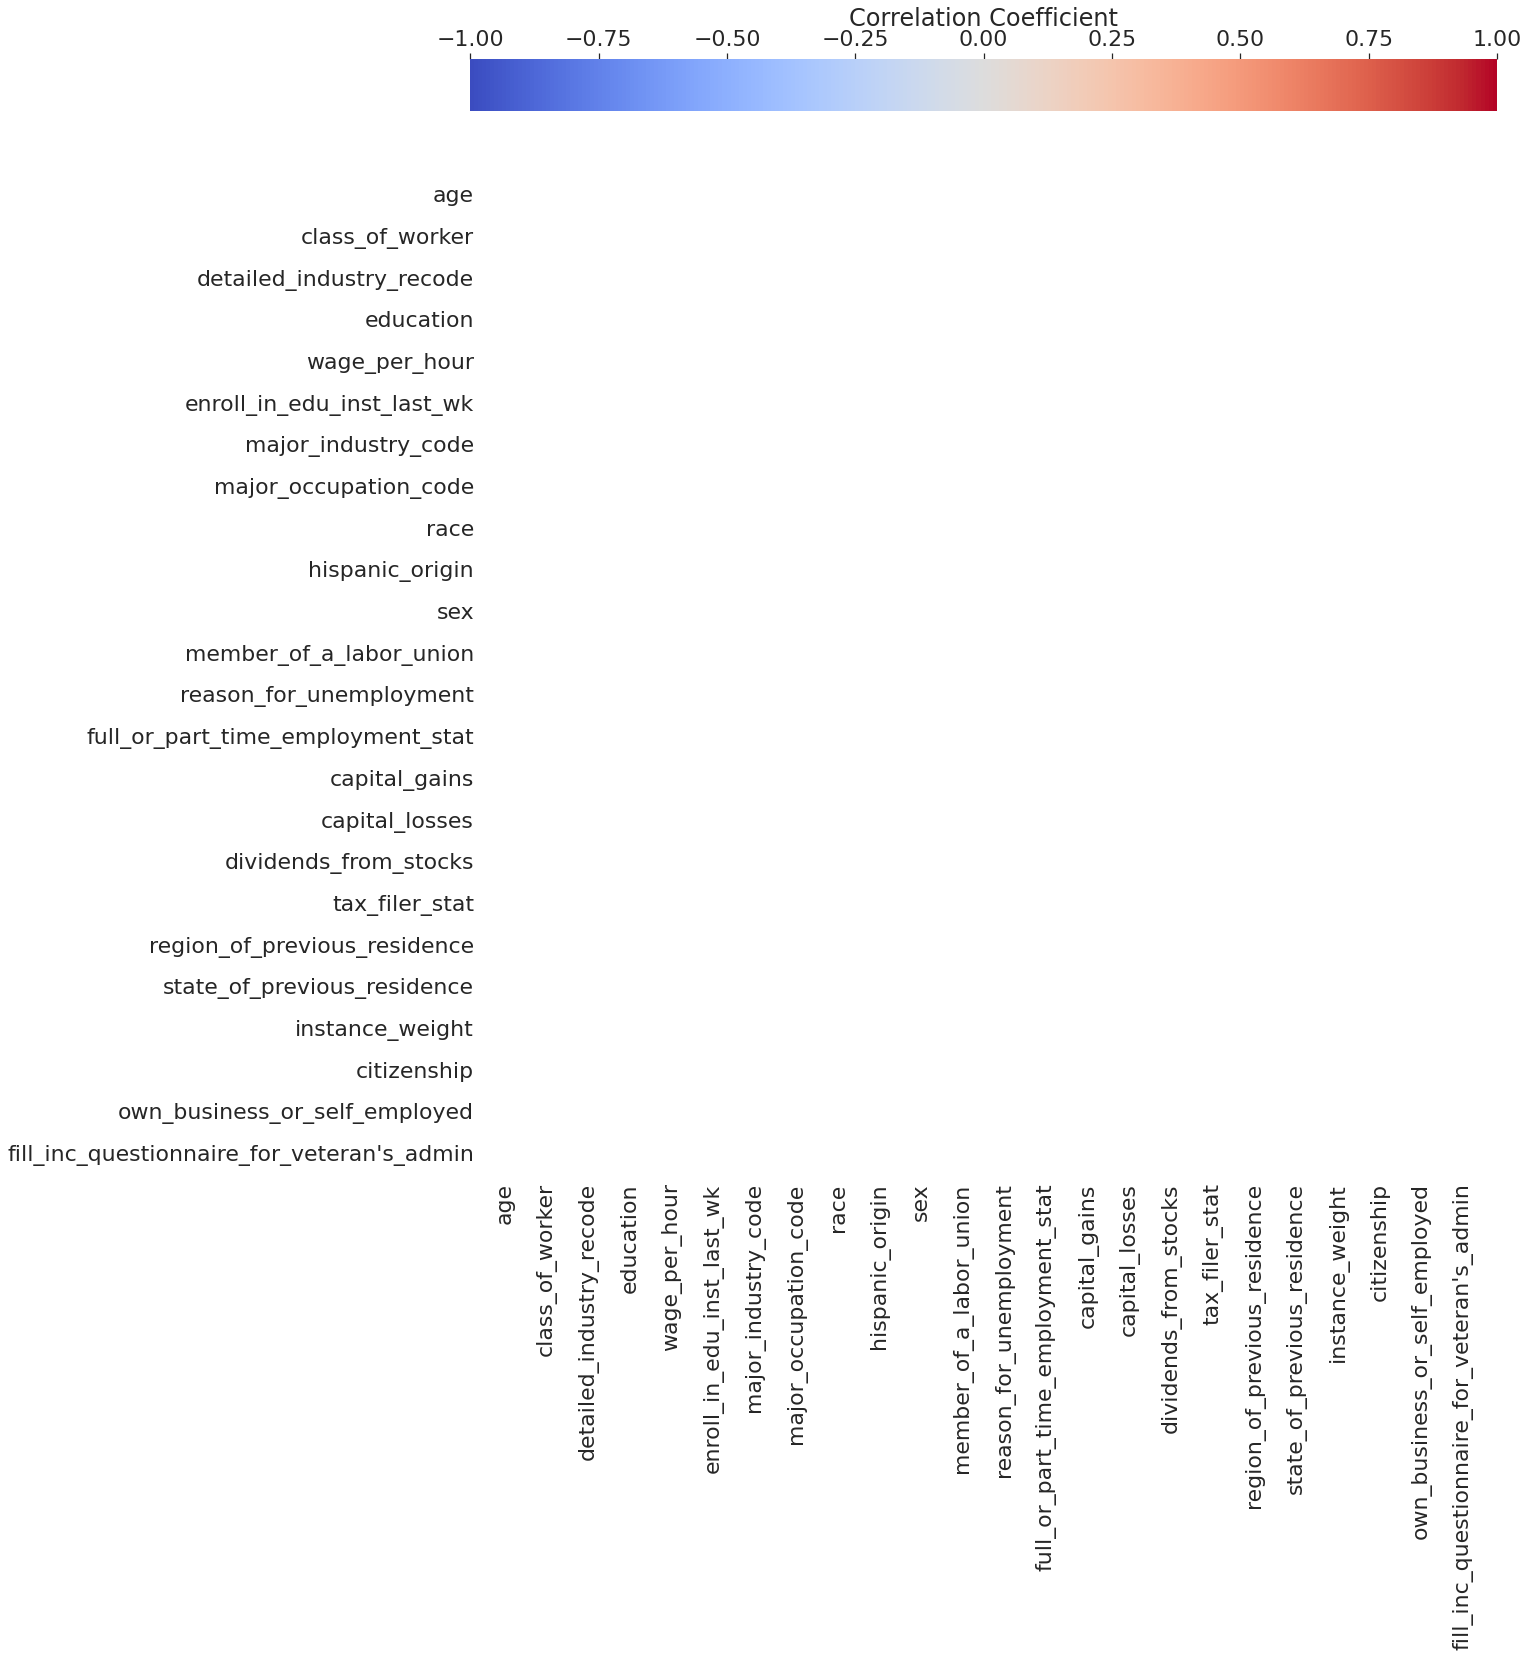

In [39]:
correlation = df.drop(['target'], axis=1).corr()
mask = np.triu(correlation)
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(23,23))
  ax = sns.heatmap(correlation[(correlation > 0.5) | (correlation < -0.5)],
  #ax = sns.heatmap(correlation,
              square=True,
              vmax=1.0,
              vmin=-1.0,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              mask=mask,
              annot=False, 
              fmt=".2f",
              robust=True,
              cbar=True,
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

**NICE!** *So no correlations greater than 0.5 or less than -0.5. Let's plot the rest:*

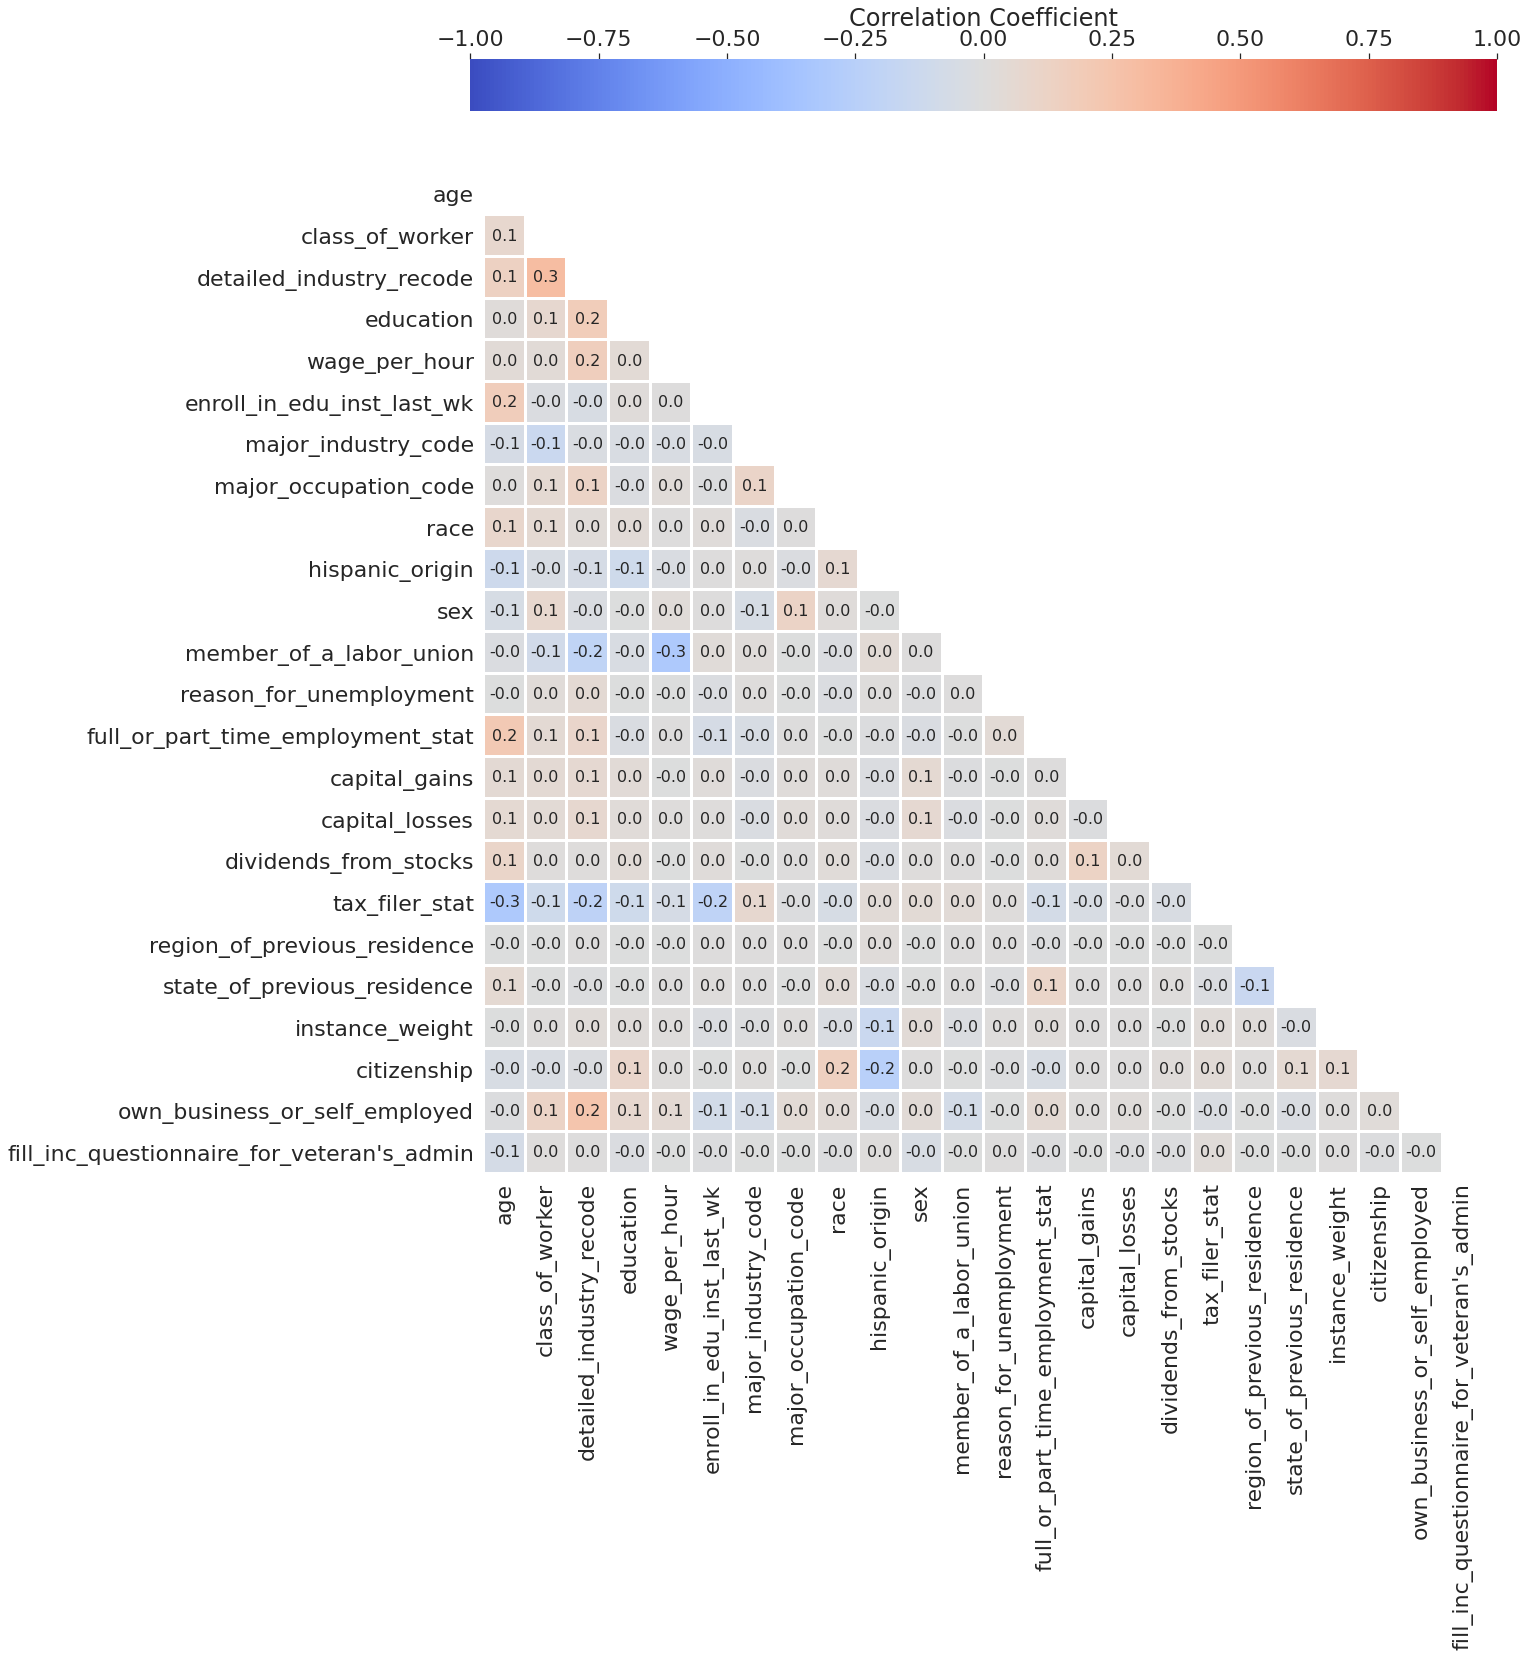

In [40]:
correlation = df.drop(['target'], axis=1).corr()
mask = np.triu(correlation)
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(23,23))
  #ax = sns.heatmap(correlation[(correlation > 0.5) | (correlation < -0.5)],
  ax = sns.heatmap(correlation,
              square=True,
              vmax=1.0,
              vmin=-1.0,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              mask=mask,
              annot=True,
              fmt=".1f",
              robust=True,
              cbar=True,
              annot_kws={"size": 16},
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

## Further EDA
Let's explore our data a little further. Then perhaps come up with a simple hypothesis to test and a prediction model

In [41]:
# Lets use the non categorized dataset for some analyses
eda = df_bkp.loc[:,df.columns.tolist()]

## Distplot

**Warm up:** Age was pointed as an important feature. Do we have a population that is equally distirbuted in terms of age? 

No. We can see that 50% of the population is 35 years old or younger. We have the next 30% at circa 60 years old or less. We can also confirm that by fitting a log-gama distribution over the data (second chart, black line).

By the manifest we know this data comprises the years 1994 and 1995. Therefore, **we can do some fact checking**: we see that indeed between 1990 and 2000 the median age of the United States was around 35 years old (despite the fact the census data only includes the Economic Active Population)

<a href="https://www.statista.com/statistics/241494/median-age-of-the-us-population/" rel="nofollow"><img src="https://www.statista.com/graphic/1/241494/median-age-of-the-us-population.jpg" alt="Statistic: Median age of the resident population of the United States from 1960 to 2019 | Statista" style="width: 100%; height: auto !important; max-width:1000px;-ms-interpolation-mode: bicubic;"/></a><br />Find more statistics at  <a href="https://www.statista.com" rel="nofollow">Statista</a>

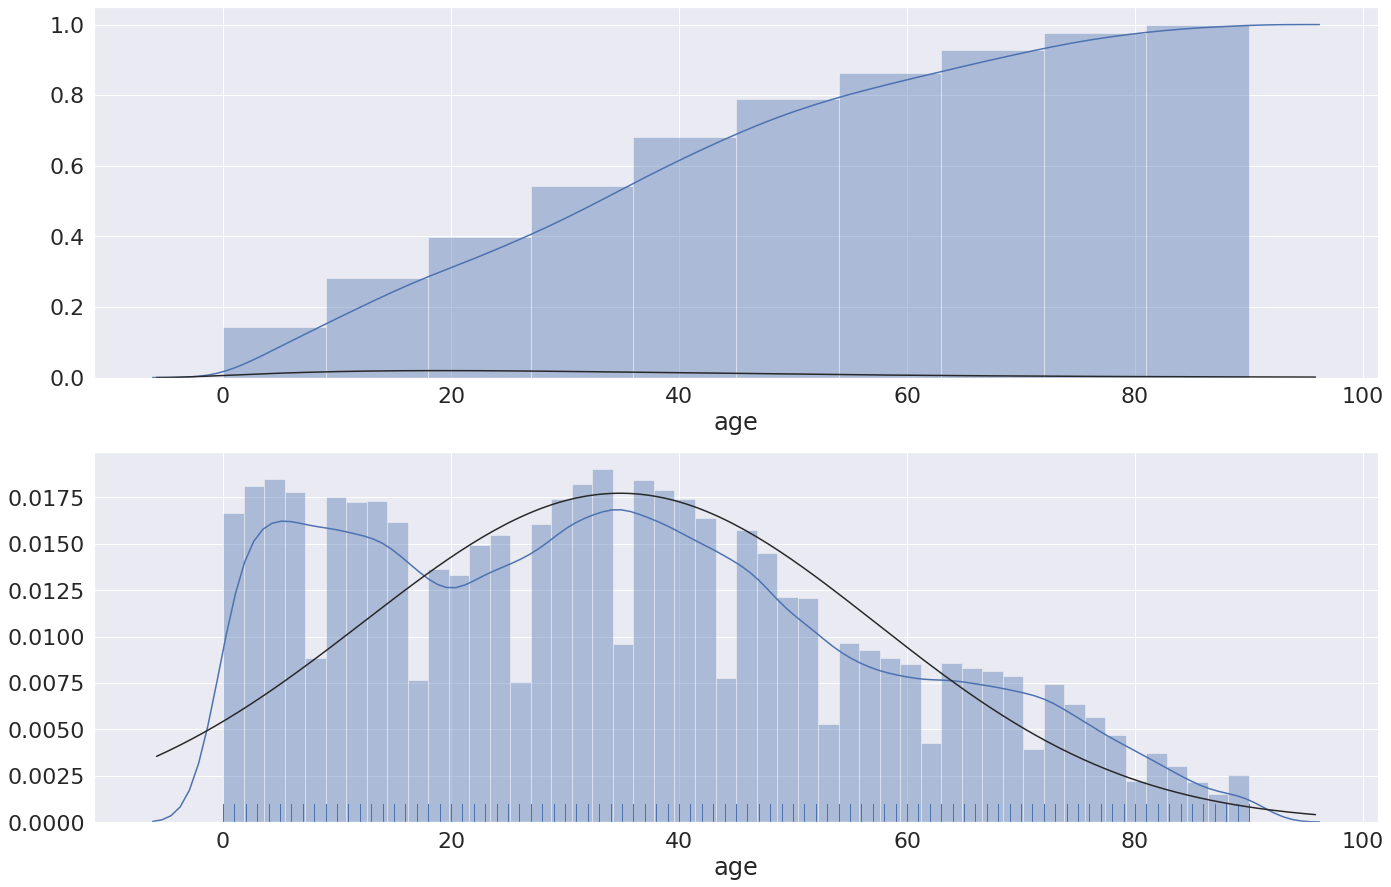

In [42]:
# Bimodal data, 50% of population less than 35yo
fig, ax = plt.subplots(2, 1, figsize=figsize)
kwargs = {'cumulative': True}

g1 = sns.distplot(eda['age'], hist_kws=kwargs, kde_kws=kwargs, ax=ax[0], axlabel=None,
                  fit=stats.gamma, bins=10)
g2 = sns.distplot(eda['age'], rug=True, ax=ax[1], fit=stats.loggamma)

How about the target by age? We can see that 50% of those earning $< 50$K are around 30~35 years old or younger. On the other hand, 50% of those earning $>50$K are older than 45 years old.

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

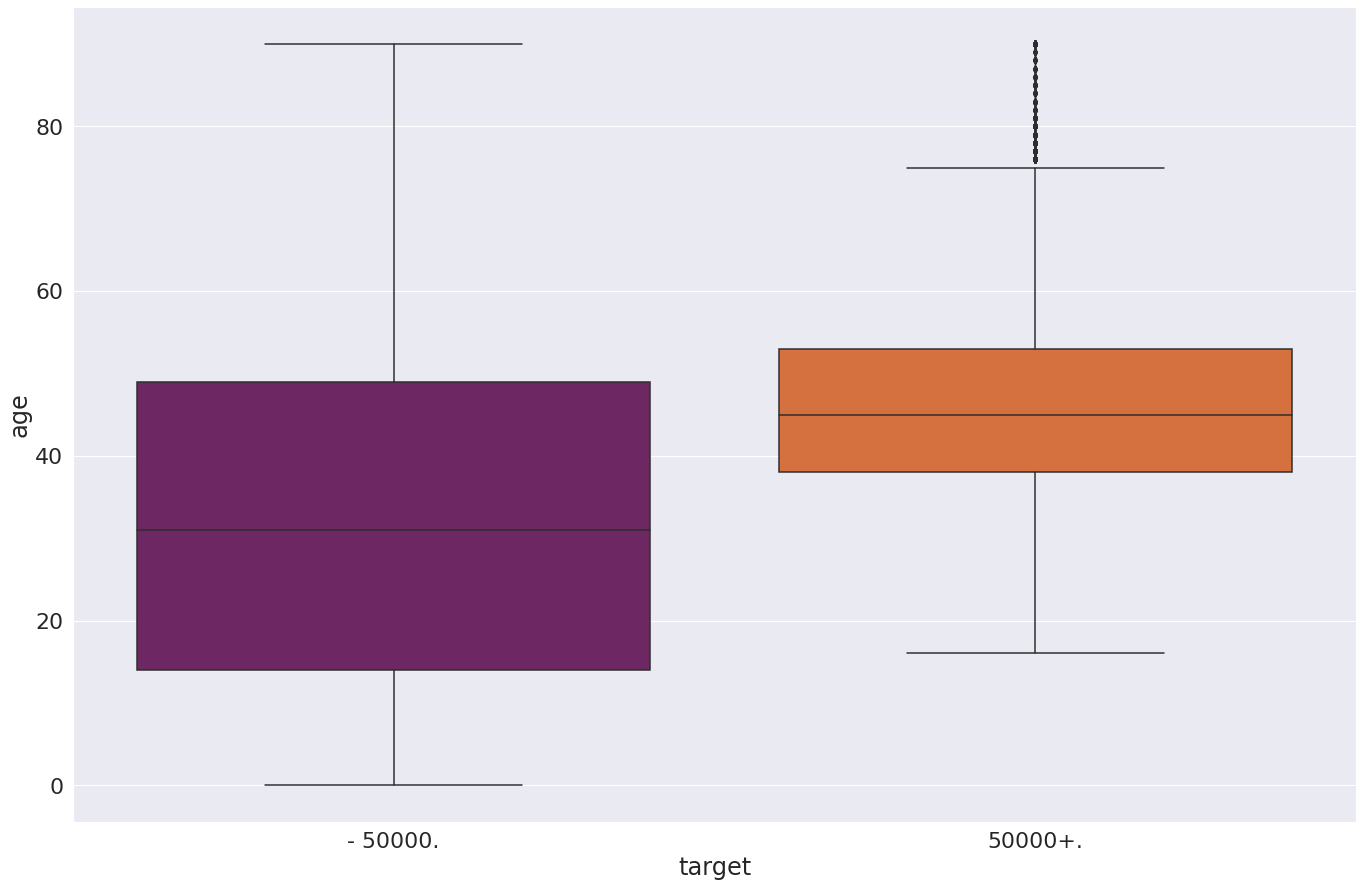

In [43]:
fig, ax = plt.subplots(figsize=(figsize))
g = sns.boxplot(y='age', x='target', data=eda, palette=pal)
plt.xticks(rotation=0)

As expected, **age** will play a role in our predictions. Common knowledge tells us that, in rare expections, someone who's starting their career will earn less than someone at more senior levels (usually a consequence of ageing). Likewise, retired people tend to earn less than those who are economically active.  This is a straight-forward assumption. **So let's try some more involved hypothesis without looking into the data.**


# Hypothesis Test 1: Constructors vs Educators

**Let's pretend we have some questions and distill the following hypothesis without looking into the data (only using statistics)**

"There's a better chance of seeing more *Construction* workers among the top earners in comparison to *Education* workers"

>$H_0: \, \, $ Equal chances of *Construction* workers and *Education* workers to earn +50K  ($\theta=0.5$)    
>$H_1: \, \, $ There's a higher chance of *Construction* workers to b earning earning  +50K versus *Education* workers ($\theta > 0.5$)  


Where $H_0$ is our null hypothesis and $H_1$ is our alternative hypothesis, our test will be conducted at a significance level of 5%


🚀 Let's ignore EDA and answer this with the right level of confidence in a statistical way



In [44]:
# Let's first compute the proportion of construction workers and educators among the top earners
test_statistic = eda[(eda.major_industry_code=="Construction")].groupby("target").count().T.reset_index().iloc[:,0:3].iloc[0][2]
complement = eda[(eda.major_industry_code=="Education")].groupby("target").count().T.reset_index().iloc[:,0:3].iloc[0][2]

# How many observations do we have in total
N = test_statistic+complement

# And for each of our target observations
print("Total people earning +50K = ", N, test_statistic+complement==N)
print("--- construction =", test_statistic)
print("--- education =", complement)

Total people earning +50K =  1424 True
--- construction = 533
--- education = 891


**To simplify, we can model this as a binomial distribution** (seeing construction workers in the high earning group is considered success)

*Level = 5%*:  Decreasing this will decrease our critical region (region where we fail
 o reject the null hypothesis if the p-value falls within)

*p=0.5:*  We want to test if the propability of seeing constructors and educators are the same

In [45]:
level=0.05
p=0.5

In [46]:
print(f"Within the 50K+ target we have seen {N} constructors and educators")
print(f"{test_statistic} of them are in the Construction Sector ({round(test_statistic/N,2)*100}%)\n")
print(f"\nH0 : The proportion of consutrction workers as top earners is the same as educators (param = {p})")
print(f"H1 : There are fewer construction workers earning 50K+ than educators (param < {p})\n")

%time p_value = [stats.binom_test(x, N, p=0.5, alternative='greater') for x in range(test_statistic)]

print("\n\tp-value", p_value[0])

print("\n", div)
if p_value[0] < level:
  print('''\nTHEREFORE We reject the null hypothesis H0.
  There is enough evidence at 5% level of significance to suggest that 
  Considering only educators and constructors,
  the observation is not due to chance
  \n>> Constructors and Educators are not equally likely among the top earners\n''')
else:
  print('''\nTHEREFORE We FAIL to reject the null hypotehesis H0.
  There is enough evidence at 5% level of significance to suggest that 
  Considering only educators and constructors,
  the observation is not due to chance
  \n>> constructors and educators are balanced as top earners\n''')
print(div)


Within the 50K+ target we have seen 1424 constructors and educators
533 of them are in the Construction Sector (37.0%)


H0 : The proportion of consutrction workers as top earners is the same as educators (param = 0.5)
H1 : There are fewer construction workers earning 50K+ than educators (param < 0.5)

CPU times: user 62.8 ms, sys: 2 ms, total: 64.8 ms
Wall time: 63.7 ms

	p-value 1.0


THEREFORE We FAIL to reject the null hypotehesis H0.
  There is enough evidence at 5% level of significance to suggest that 
  Considering only educators and constructors,
  the observation is not due to chance
  
>> constructors and educators are balanced as top earners



# Hypothesis 2: What if we compare Education against Entertainment workers? 

**Let's distill the following hypothesis:**

"US is the land of Holywood and we know many people don't have access to good education. So Education workers are less prone to be among top earners (50K+) than Entertainment workers". 

>$H_0: \, \, $ Equal chance of *Education* workers earning  +50K,as *Educators* workers   ($\theta=0.5$)    
>$H_1: \, \, $ There's a lower chance of seeing *Education* workers earning  +50K in comparison to *Entertainment* workers ($\theta < 0.5$)  


Once again, $H_0$ is our null hypothesis and $H_1$ is our alternative hypothesis, our test will be conducted at a significance level of 5%


🚀 No EDA, yes Stats.



In [47]:
# Let's first compute the proportion of construction workers and educators among the top earners
test_statistic = eda[(eda.major_industry_code=="Education")].groupby("target").count().T.reset_index().iloc[:,0:3].iloc[0][2]
complement =  eda[(eda.major_industry_code=="Entertainment")].groupby("target").count().T.reset_index().iloc[:,0:3].iloc[0][2]

# How many observations do we have in total
N = test_statistic+complement
print("Total people earning +50K = ", N, test_statistic+complement==N)
print("--- Education =", test_statistic)
print("--- Entertainment =", complement)

Total people earning +50K =  1004 True
--- Education = 891
--- Entertainment = 113


In [48]:
level=0.05
p=0.5

In [49]:
print(f"Within the 50K+ target we have seen {N} Educators and Entertainers")
print(f"{test_statistic} of them are in the Educators Sector ({round(test_statistic/N,2)*100}%)\n")
print(f"\nH0 : The proportion of Educators workers as top earners is the same as Entertainers (param = {p})")
print(f"H1 : There are fewer Education workers earning 50K+ than Entertainers (param < {p})\n")

%time p_value = [stats.binom_test(x, N, p=0.5, alternative='less') for x in range(test_statistic)]

print("\n\tp-value", p_value[0])

print("\n", div)

if p_value[0] < level:
  print('''\nTHEREFORE We reject the null hypothesis H0.
  There is enough evidence at 5% level of significance to suggest that,
  Considering only Educators and Entertainers,
  the observation is not due to chance
  \n>> there are more Educators than Entertainers in the top earners\n''')
else:
  print('''\nTHEREFORE We FAIL to reject the null hypotehesis H0.
  There is enough evidence at 5% level of significance to suggest that 
  the observation is not due to chance
  \n>> Educators and Entertainers are balanced among top earners\n''')
print(div)


Within the 50K+ target we have seen 1004 Educators and Entertainers
891 of them are in the Educators Sector (89.0%)


H0 : The proportion of Educators workers as top earners is the same as Entertainers (param = 0.5)
H1 : There are fewer Education workers earning 50K+ than Entertainers (param < 0.5)

CPU times: user 119 ms, sys: 4.2 ms, total: 123 ms
Wall time: 118 ms

	p-value 5.832897615645118e-303


THEREFORE We reject the null hypothesis H0.
  There is enough evidence at 5% level of significance to suggest that,
  Considering only Educators and Entertainers,
  the observation is not due to chance
  
>> there are more Educators than Entertainers in the top earners



## Machine Learning

## Split Train into Train (70%) & Validation (30%)

In [50]:
t_df[df.columns].dtypes == df.dtypes

age                                           True
class_of_worker                               True
detailed_industry_recode                      True
education                                     True
wage_per_hour                                 True
enroll_in_edu_inst_last_wk                    True
major_industry_code                           True
major_occupation_code                         True
race                                          True
hispanic_origin                               True
sex                                           True
member_of_a_labor_union                       True
reason_for_unemployment                       True
full_or_part_time_employment_stat             True
capital_gains                                 True
capital_losses                                True
dividends_from_stocks                         True
tax_filer_stat                                True
region_of_previous_residence                  True
state_of_previous_residence    

In [51]:
X = df.iloc[:,:-1].copy()
y = df.iloc[:,-1].copy()
xtest = t_df.iloc[:,:-1].copy()
ytest = t_df.iloc[:,-1].copy() 

xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3, random_state=42)

## XGBOOST
Please note this is not the Scikit-learn API but the python API: https://xgboost.readthedocs.io/en/latest/python/python_intro.html which provides better support for GPUs

In [52]:
# instantiate params
params = {}

# general params
general_params = {'silent': 1,
                  'lambda': 0.02,
                  'learning_rate': 0.07,
                  'max_depth': 16}
params.update(general_params)

# booster params
n_gpus = 1  # change this to -1 to use all GPUs available or 0 to use the CPU
booster_params = {}

if n_gpus != 0:
    booster_params['tree_method'] = 'gpu_hist'
    booster_params['n_gpus'] = n_gpus   
params.update(booster_params)

# learning task params
learning_task_params = {}
learning_task_params['eval_metric'] = ['logloss']
learning_task_params['objective'] = 'reg:logistic'

params.update(learning_task_params)

In [53]:
model = XGBClassifier(**params, n_estimators=1000, early_stopping_rounds=10, verbose=2)

In [54]:
print("Train...")
%time model.fit(xtrain, ytrain)

print("\nPredict (Validation)...")
%time y_pred = model.predict(xvalid)
predictions=[round(value) for value in y_pred]

Train...
CPU times: user 27.1 s, sys: 3.31 s, total: 30.4 s
Wall time: 30.4 s

Predict (Validation)...
CPU times: user 32.5 ms, sys: 6.02 ms, total: 38.5 ms
Wall time: 38 ms


### Prediction on Validation Set

In [55]:
# This is how many records we have in the validation set
pd.Series(yvalid).value_counts()

0    55156
1     3733
Name: target, dtype: int64

In [56]:
accuracy = accuracy_score(yvalid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

rmse = np.sqrt(mean_squared_error(yvalid, y_pred))
print("RMSE: %f" % (rmse))

Accuracy: 95.20%
RMSE: 0.219063


Text(0.5, 0.98, '\nConfusion Matrix on VALIDATION Set')

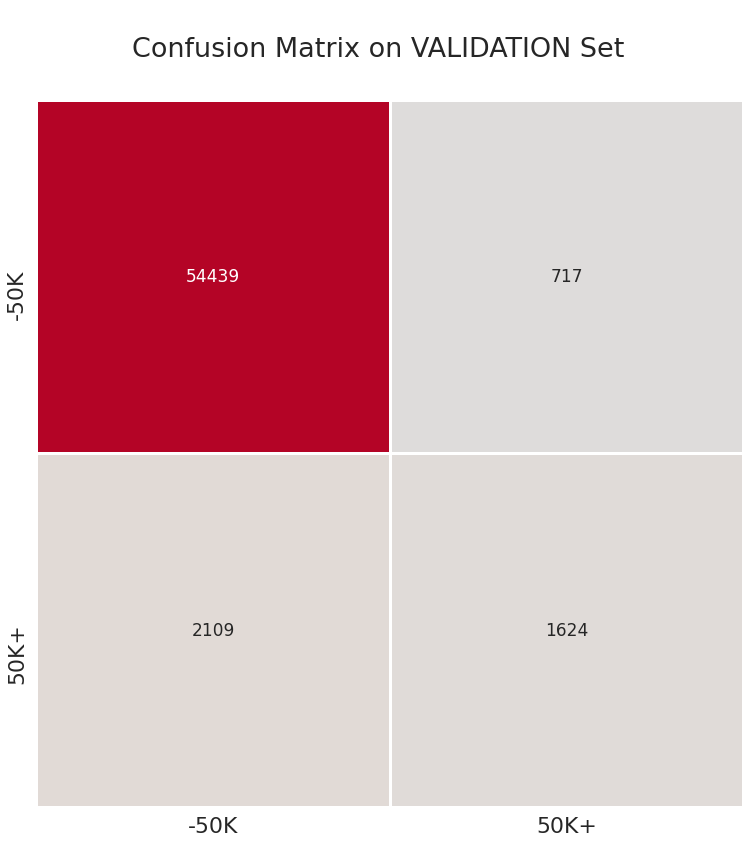

In [57]:
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(13,13))
  ax = sns.heatmap(confusion_matrix(yvalid, predictions),
              square=True,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              annot=True, 
              fmt="d",
              robust=True,
              cbar=False,
              yticklabels=["-50K", "50K+"],
              xticklabels=["-50K", "50K+"],
              annot_kws={'fontsize': 17},
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

plt.suptitle("\nConfusion Matrix on VALIDATION Set", fontsize=27)

In [58]:
print(classification_report(yvalid,predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     55156
           1       0.69      0.44      0.53      3733

    accuracy                           0.95     58889
   macro avg       0.83      0.71      0.75     58889
weighted avg       0.95      0.95      0.95     58889




### Prediction on Test Set

In [59]:
# This is how many values we have in the Test Set
ytest.value_counts()

0    93576
1     6186
Name: target, dtype: int64

In [60]:
print("\nPredict (Test)...")

y_pred=model.predict(xtest[df.iloc[:,:-1].columns])
predictions=[round(value) for value in y_pred]

accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print("RMSE: %f" % (rmse))


Predict (Test)...
Accuracy: 95.370%
RMSE: 0.215175


Text(0.5, 0.98, '\nConfusion Matrix on Test Set')

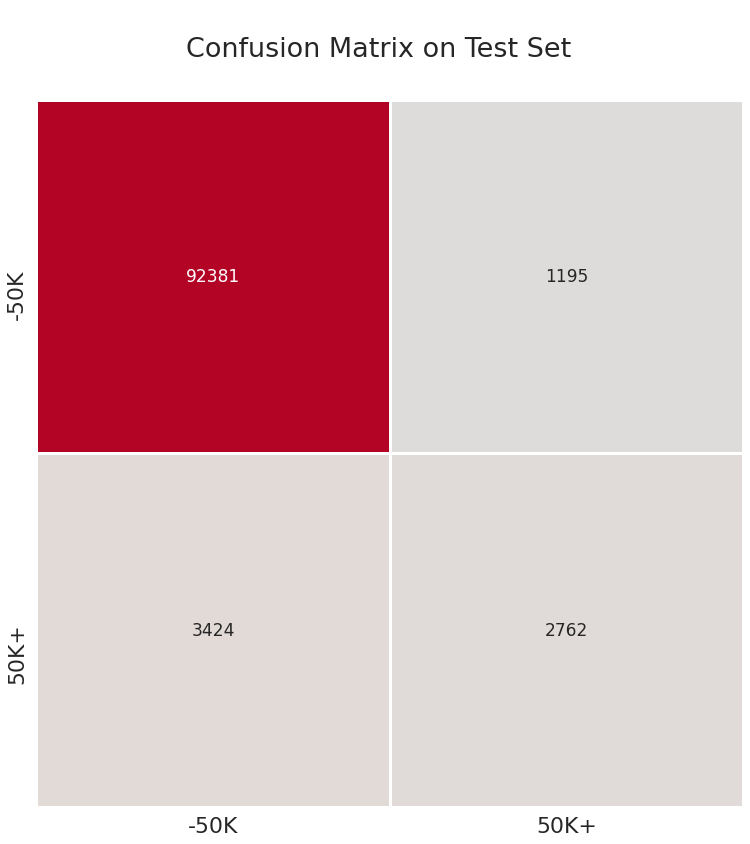

In [61]:
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(13,13))
  ax = sns.heatmap(confusion_matrix(ytest, predictions),
              square=True,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              annot=True, 
              fmt="d",
              robust=True,
              cbar=False,
              yticklabels=["-50K", "50K+"],
              xticklabels=["-50K", "50K+"],
              annot_kws={'fontsize': 17},
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

plt.suptitle("\nConfusion Matrix on Test Set", fontsize=27)

In [62]:
print(classification_report(ytest,predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     93576
           1       0.70      0.45      0.54      6186

    accuracy                           0.95     99762
   macro avg       0.83      0.72      0.76     99762
weighted avg       0.95      0.95      0.95     99762



###  Prediction with balanced and normalised data

In [63]:
X = df.iloc[:,:-1].copy()
y = df.iloc[:,-1].copy()

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
X = pd.DataFrame(X, columns=df.iloc[:,:-1].columns)
y = pd.Series(y); 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train...
CPU times: user 28.8 s, sys: 3.79 s, total: 32.6 s
Wall time: 32.6 s

Predict (Validation)...
CPU times: user 52.4 ms, sys: 7.96 ms, total: 60.3 ms
Wall time: 59.4 ms
Accuracy: 97.54%
RMSE: 0.156712


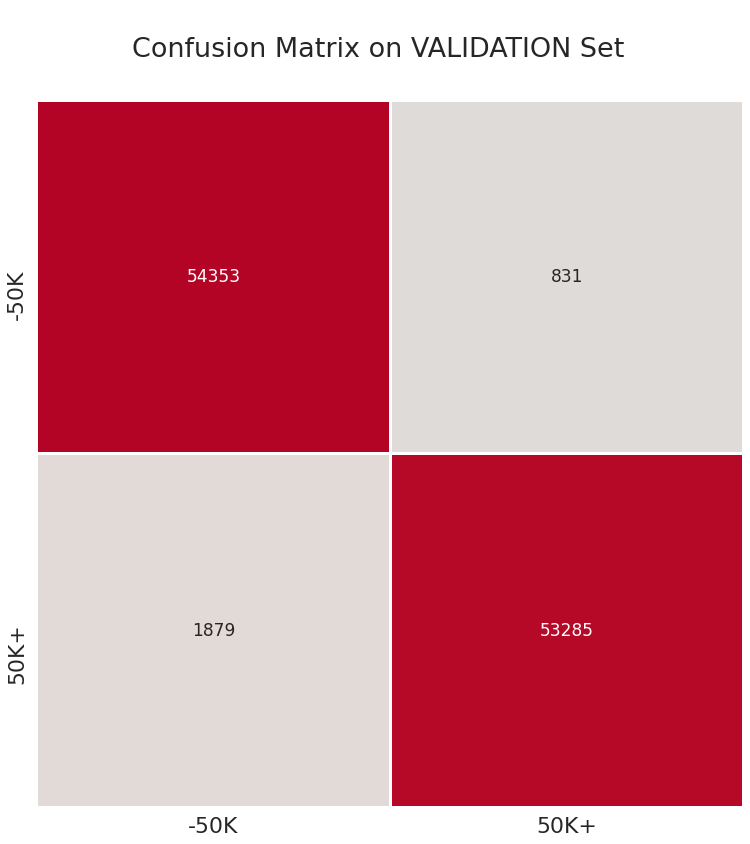

In [64]:
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = Normalizer().fit(xtrain)

model_norm = XGBClassifier(**params, n_estimators=1000, early_stopping_rounds=10, verbose=2)

print("Train...")
%time model_norm.fit(xtrain, ytrain)

print("\nPredict (Validation)...")
%time y_pred = model_norm.predict(xvalid)
predictions=[round(value) for value in y_pred]

accuracy = accuracy_score(yvalid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

rmse = np.sqrt(mean_squared_error(yvalid, y_pred))
print("RMSE: %f" % (rmse))

with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(13,13))
  ax = sns.heatmap(confusion_matrix(yvalid, predictions),
              square=True,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              annot=True, 
              fmt="d",
              robust=True,
              cbar=False,
              yticklabels=["-50K", "50K+"],
              xticklabels=["-50K", "50K+"],
              annot_kws={'fontsize': 17},
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

plt.suptitle("\nConfusion Matrix on VALIDATION Set", fontsize=27)

print(div)

In [65]:
print(classification_report(yvalid,predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     55184
           1       0.98      0.97      0.98     55164

    accuracy                           0.98    110348
   macro avg       0.98      0.98      0.98    110348
weighted avg       0.98      0.98      0.98    110348




Predict (Test)...
Accuracy: 95.390%
RMSE: 0.214708
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     93576
           1       0.69      0.47      0.56      6186

    accuracy                           0.95     99762
   macro avg       0.83      0.73      0.77     99762
weighted avg       0.95      0.95      0.95     99762



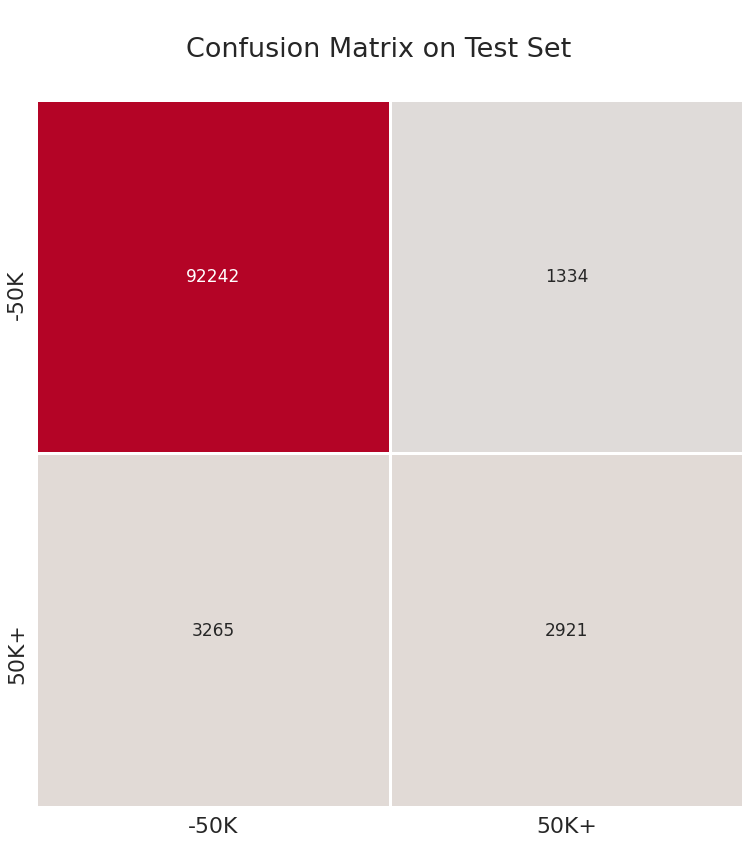

In [66]:
print("\nPredict (Test)...")
y_pred = model_norm.predict(xtest[df.iloc[:,:-1].columns])
predictions=[round(value) for value in y_pred]

accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print("RMSE: %f" % (rmse))

with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(13,13))
  ax = sns.heatmap(confusion_matrix(ytest, predictions),
              square=True,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              annot=True, 
              fmt="d",
              robust=True,
              cbar=False,
              yticklabels=["-50K", "50K+"],
              xticklabels=["-50K", "50K+"],
              annot_kws={'fontsize': 17},
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

plt.suptitle("\nConfusion Matrix on Test Set", fontsize=27)

print(classification_report(ytest,predictions))
prob_xgboost_norm = model.predict_proba(xtest[df.iloc[:,:-1].columns])


> **Oh no! It seems like that the SMOTE method makes us overfit in the validation set.** I still prefer the non-scaled method as it helps us generalise better onto unseen data.

## SVM

An alternative method to explore would be SVM. However, SVMs depend on "support vectors" and their large margins. It is very sensitive to unbalanced datasets e the data must be scaled (some people use PCA).

SVM is robust, but it is time consuming with complecity that can reach $O(N^2*K)$. Since we have performed well with XGBoost on both validation and test sets, this could be our model of choice in this example

#THE END ✌


**Some questions to reflect upon:**

1. **Normalise / scale the data?**
SVM exploits distances and similarities from large margins so it needs some sort of scaling to avoid creating support vectors that are wrongfully importance. I chose Normalisation on XgBoost because it uses 'l2' norm and makes the data resemble a gaussian distribution. This form of scaling is good for the linear kernel on SVMs, but XGBoost is a tree based ensemble, which is scale invariant, so it doesn't require scaling despite the fact that I did it in one of the experiments

2. **Caveats with oversample / downsample?**
Becuase I prefer modelling upon the true nature of the data choosing models that are less sensitive to scale imbalance or that accounts for it in a proper way. Despite good initial test accuracy, SVM can struggle with class imbalance and Takes a **long time** to run, especially with GridSearch. I'd use SMOTE to oversample the minority class should SVM be the model of choice

3. **No feature engineering?**
We have a dataset that is not very large and it is not showing signs of overfitting given the results in the validation and test sets. So the trade-off bias / variance shouldn't be a great issue. With 41 features and less than 200K training examples, feature engineering might be overkill and lead to overfitting. It's better to first come up with a good model. *The metadata* states: *Probability for the label '- 50000' : 93.80% *and *Probability for the label '50000+' : 6.20%*. We have surpassed that score on our first model by making the right assumptions / treating the data. 

5. **More EDA?**
Since I knew the objective was classification over a linearly-separable setting, I focused on EDA for model preparation rather than trying to understand US' macroeconomy. There are several questions to ask (more hypothesis) such as the relationship between race, sex and wage. Wether citizenship is related to industry, etc.... it depends on the objetive of the analysis.

6. **Deep Learning?**
Overkill for 200,000 linearly separable training examples. This is a rather small dataset and we can achieve good performance (how much is good enough?) with XGBoost straightaway

7. **Future work?** Defintely. There are so many ways to improve this notebook. More experiments, more models, more EDAs, use of external data, change the target variable, Shufftle Datasets... We could try modle stacking, etc.... In short, there are many possibilities to explore and this can be an (theoretically) endless notebook